In [1]:
import pandas as pd
import numpy as np
import requests
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

from tqdm import tqdm

In [2]:
# Journal impact factors: Source: https://www.scimagojr.com/journalrank.php
j_list = pd.read_csv('scimagojr 2022.csv', sep=';')
j_list.head()

,Rank,Sourceid,Title,Type,Issn,SJR,SJR Best Quartile,H index,Total Docs. (2022),Total Docs. (3years),...,Total Cites (3years),Citable Docs. (3years),Cites / Doc. (2years),Ref. / Doc.,Country,Region,Publisher,Coverage,Categories,Areas
0,1,28773,Ca-A Cancer Journal for Clinicians,journal,"15424863, 00079235","86,091",Q1,198,44,118,...,30318,85,"299,99","97,00",United States,Northern America,Wiley-Blackwell,1950-2022,Hematology (Q1); Oncology (Q1),Medicine
1,2,29431,Quarterly Journal of Economics,journal,"00335533, 15314650","36,730",Q1,292,36,122,...,2141,122,"14,83","66,61",United Kingdom,Western Europe,Oxford University Press,1886-2022,Economics and Econometrics (Q1),"Economics, Econometrics and Finance"
2,3,20315,Nature Reviews Molecular Cell Biology,journal,"14710072, 14710080","34,201",Q1,485,121,328,...,13331,156,"35,47","89,29",United Kingdom,Western Europe,Nature Publishing Group,2000-2022,Cell Biology (Q1); Molecular Biology (Q1),"Biochemistry, Genetics and Molecular Biology"
3,4,18434,Cell,journal,"00928674, 10974172","26,494",Q1,856,420,1637,...,67791,1440,"43,80","65,74",United States,Northern America,Cell Press,1974-2022,"Biochemistry, Genetics and Molecular Biology (...","Biochemistry, Genetics and Molecular Biology"
4,5,15847,New England Journal of Medicine,journal,"00284793, 15334406","26,015",Q1,1130,1410,4561,...,133956,1854,"33,93","10,21",United States,Northern America,Massachussetts Medical Society,1945-2022,Medicine (miscellaneous) (Q1),Medicine


In [3]:
j_list

,Rank,Sourceid,Title,Type,Issn,SJR,SJR Best Quartile,H index,Total Docs. (2022),Total Docs. (3years),...,Total Cites (3years),Citable Docs. (3years),Cites / Doc. (2years),Ref. / Doc.,Country,Region,Publisher,Coverage,Categories,Areas
0,1,28773,Ca-A Cancer Journal for Clinicians,journal,"15424863, 00079235","86,091",Q1,198,44,118,...,30318,85,"299,99","97,00",United States,Northern America,Wiley-Blackwell,1950-2022,Hematology (Q1); Oncology (Q1),Medicine
1,2,29431,Quarterly Journal of Economics,journal,"00335533, 15314650","36,730",Q1,292,36,122,...,2141,122,"14,83","66,61",United Kingdom,Western Europe,Oxford University Press,1886-2022,Economics and Econometrics (Q1),"Economics, Econometrics and Finance"
2,3,20315,Nature Reviews Molecular Cell Biology,journal,"14710072, 14710080","34,201",Q1,485,121,328,...,13331,156,"35,47","89,29",United Kingdom,Western Europe,Nature Publishing Group,2000-2022,Cell Biology (Q1); Molecular Biology (Q1),"Biochemistry, Genetics and Molecular Biology"
3,4,18434,Cell,journal,"00928674, 10974172","26,494",Q1,856,420,1637,...,67791,1440,"43,80","65,74",United States,Northern America,Cell Press,1974-2022,"Biochemistry, Genetics and Molecular Biology (...","Biochemistry, Genetics and Molecular Biology"
4,5,15847,New England Journal of Medicine,journal,"00284793, 15334406","26,015",Q1,1130,1410,4561,...,133956,1854,"33,93","10,21",United States,Northern America,Massachussetts Medical Society,1945-2022,Medicine (miscellaneous) (Q1),Medicine
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27950,27951,21101091736,Worldwide Waste,journal,23997117,NaN,-,1,5,0,...,0,0,"0,00","64,00",United Kingdom,Western Europe,Web Portal Ubiquity Press,2022,Waste Management and Disposal,Environmental Science
27951,27952,17700156005,WSEAS Transactions on Heat and Mass Transfer (...,journal,17905044,NaN,-,10,24,0,...,0,0,"0,00","24,71",Greece,Western Europe,World Scientific and Engineering Academy and S...,"2009-2015, 2022",Condensed Matter Physics; Energy (miscellaneou...,Energy; Engineering; Physics and Astronomy
27952,27953,21100829466,Yearbook of Comparative Literature,journal,"19255772, 19255764",NaN,-,4,9,0,...,0,0,"0,00","45,78",Canada,Northern America,University of Toronto Press,"2009-2011, 2013-2017",Cultural Studies; History; Literature and Lite...,Arts and Humanities; Social Sciences
27953,27954,21100212328,Zbornik za Umetnostno Zgodovino,journal,"0351224X, 15803767",NaN,-,3,1,0,...,0,0,"0,00","0,00",Slovenia,Eastern Europe,Slovene Art History Society,2011-2018,History; Visual Arts and Performing Arts,Arts and Humanities


In [4]:
def search_pubmed(query, max_results=None):
    base_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi"
    params = {
        "db": "pubmed",
        "term": query,
        "retmax": max_results
    }

    if max_results:
        params["retmax"] = max_results
    
    response = requests.get(base_url, params=params)
    if response.status_code != 200:
        print("Error: Unable to fetch data from PubMed")
        return []

    root = ET.fromstring(response.content)
    pmids = [id_elem.text for id_elem in root.findall("IdList/Id")]
    return pmids

In [5]:
def fetch_details(pmids):
    ids = ",".join(pmids)
    base_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi"
    params = {
        "db": "pubmed",
        "retmode": "xml",
        "id": ids
    }

    response = requests.get(base_url, params=params)
    if response.status_code != 200:
        print("Error: Unable to fetch details from PubMed")
        return None

    return response.content

In [6]:
def parse_pubmed_efetch(xml_data):
    root = ET.fromstring(xml_data)

    articles = []
    for article in root.findall('.//PubmedArticle'):
        title = article.find('.//ArticleTitle').text

        journal_title = article.find('.//Journal/Title').text
        
        authors = []
        for author in article.findall('.//Author'):
            lastname = author.find('LastName')
            firstname = author.find('ForeName')
            if lastname is not None and firstname is not None:
                authors.append(f"{firstname.text} {lastname.text}")

        articles.append({'title': title, 'journal': journal_title, 'authors': authors})

    return articles

In [7]:
input_data = pd.read_csv('drug_cell_gene.csv.gz', index_col=0)
attention = pd.read_csv('attention.csv.gz', index_col=0)
attention.index = input_data.index
attention.columns = input_data.columns
attention

/var/folders/s4/6xgylm7x3yzgfsk6sbvk_7_c0000gn/T/ipykernel_10862/320700327.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  input_data = pd.read_csv('/Users/yoshitakainoue/Downloads/drug_cell_gene.csv.gz', index_col=0)


,740,752,755,762,1390,1895,3053,3088,6396,8806,...,ZNF207,ZNF22,ZNF580,ZNF593,ZNF706,ZNHIT1,ZNHIT3,ZNRD1,ZWINT,ZYX
740,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.003412,0.003558,0.003408,0.003410,0.003498,0.003412,0.003494,0.003540,0.003394,0.003387
752,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.003327,0.003505,0.003340,0.003308,0.003361,0.003338,0.003412,0.003434,0.003295,0.003294
755,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.003307,0.003430,0.003286,0.003286,0.003371,0.003272,0.003372,0.003386,0.003289,0.003258
762,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.003330,0.003448,0.003285,0.003300,0.003380,0.003285,0.003378,0.003418,0.003271,0.003272
1390,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.003382,0.003535,0.003351,0.003374,0.003419,0.003370,0.003442,0.003498,0.003341,0.003323
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZNHIT1,0.000404,0.000319,0.000413,0.000323,0.000405,0.000415,0.000411,0.000313,0.000312,0.000314,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ZNHIT3,0.000419,0.000321,0.000419,0.000320,0.000415,0.000422,0.000421,0.000312,0.000313,0.000314,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ZNRD1,0.000407,0.000317,0.000414,0.000319,0.000407,0.000416,0.000411,0.000313,0.000312,0.000314,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ZWINT,0.000398,0.000316,0.000404,0.000315,0.000402,0.000411,0.000408,0.000309,0.000305,0.000310,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [8]:
att_dg = attention.iloc[:269, 329:]
att_dg

,A2M,AAK1,ABCB1,ABL1,ABL2,ABRACL,ACAT1,ACKR3,ACLY,ACO2,...,ZNF207,ZNF22,ZNF580,ZNF593,ZNF706,ZNHIT1,ZNHIT3,ZNRD1,ZWINT,ZYX
740,0.003684,0.000000,0.003669,0.000000,0.000000,0.003496,0.003454,0.003605,0.003355,0.003446,...,0.003412,0.003558,0.003408,0.003410,0.003498,0.003412,0.003494,0.003540,0.003394,0.003387
752,0.003608,0.004824,0.003581,0.004963,0.004949,0.003423,0.003373,0.003529,0.003250,0.003382,...,0.003327,0.003505,0.003340,0.003308,0.003361,0.003338,0.003412,0.003434,0.003295,0.003294
755,0.003530,0.000000,0.003582,0.000000,0.000000,0.003360,0.003335,0.003479,0.003221,0.003301,...,0.003307,0.003430,0.003286,0.003286,0.003371,0.003272,0.003372,0.003386,0.003289,0.003258
762,0.003530,0.004777,0.003577,0.004939,0.004880,0.003393,0.003360,0.003474,0.003244,0.003318,...,0.003330,0.003448,0.003285,0.003300,0.003380,0.003285,0.003378,0.003418,0.003271,0.003272
1390,0.003637,0.000000,0.003649,0.000000,0.000000,0.003456,0.003425,0.003601,0.003295,0.003382,...,0.003382,0.003535,0.003351,0.003374,0.003419,0.003370,0.003442,0.003498,0.003341,0.003323
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
772992,0.003556,0.000000,0.003533,0.000000,0.000000,0.003360,0.003360,0.003477,0.003229,0.003312,...,0.003313,0.003437,0.003282,0.003307,0.003352,0.003297,0.003363,0.003401,0.003251,0.003257
783107,0.003630,0.004834,0.003642,0.004972,0.004920,0.003450,0.003415,0.003566,0.003282,0.003380,...,0.003364,0.003489,0.003333,0.003337,0.003427,0.003352,0.003422,0.003481,0.003323,0.003296
784722,0.003471,0.000000,0.003424,0.000000,0.000000,0.003279,0.003245,0.003355,0.003149,0.003245,...,0.003215,0.003329,0.003229,0.003203,0.003280,0.003220,0.003269,0.003314,0.003185,0.003187
789797,0.003532,0.004745,0.003518,0.004916,0.004857,0.003357,0.003336,0.003449,0.003204,0.003296,...,0.003284,0.003394,0.003263,0.003237,0.003327,0.003261,0.003307,0.003368,0.003253,0.003222


In [9]:
conv = dict(pd.read_csv('nsc_dti.csv', index_col=0)[['NSC', 'Drug Name']].values)
conv

{1: 'tolylquinone',
 17: '4-AMINO-3-PENTADECYLPHENOL',
 89: '(dimethylamino)propiophenone hydrochloride',
 185: 'Cactinomycin',
 758187: 'cycloheximide (usan)',
 295: '2-Phenylbutyric Acid',
 353: 'CHLORO-9-[[3-(DIETHYLAMINO)PROPYL]AMINO]-2-METHOXYACRIDI...',
 384: '7-CHLORO-9-[[3-(DIPENTYLAMINO)PROPYL]AMINO]-1,2,3,4-TETR...',
 596: '3-BROMO-2,4,6-TRINITROTOLUENE',
 629: 'Bioxiran',
 721: 'isatin thiosemicarbazone',
 739: 'AMINOPTERIN',
 757427: 'AMINOPTERIN',
 740: 'METHOTREXATE',
 742: 'azaserin',
 749: '8-Azaguanine',
 752: '6-THIOGUANINE',
 757348: '6-Thioguanine',
 755: '6-MERCAPTOPURINE',
 759614: '6-Mercaptopurine',
 757: 'Colchicine',
 756702: 'COLCHICINE',
 762: 'Nitrogen mustard',
 798: '3-PHENYL-1-(2-PYRIDYL)-2-PROPEN-1-ONE',
 830: '4-Pyridineacrylic acid',
 885: "3,3'-DIAMINO-4,4'-BIS(DIMETHYLAMINO)BENZOPHENONE",
 1010: '7-[.ALPHA.-(P-NITROANILINO)BENZYL]-8-QUINOLINOL',
 1011: 'P-[[.ALPHA.-(8-HYDROXY-7-QUINOLYL)BENZYL]AMINO]BENZOIC ACID',
 1012: 'wln: t66 bnj iyr&mr bvq& jq

In [10]:
results = []
for drug in tqdm(att_dg.index):
    genes = list(att_dg.loc[drug].sort_values(ascending=False).head(5).index)
    
    if any(gene in ['TOP2A', 'TOP2B'] for gene in genes):
        genes.append('TOP2')
    
    for gene in genes:
        
        d = conv[int(drug)]
        if d == 'benzaldehyde (BEN)':
            d = 'benzaldehyde'
        elif 'Derivative' in d:
            d = d[:-11]

        if 'ADA' == gene:
            gene = 'adenosine deaminase'    
        
        pmids = search_pubmed("{} AND {}".format(d, gene), max_results=300)            
        details = fetch_details(pmids)
        if details != None:
            details = details.decode('utf-8')
            res = pd.DataFrame(parse_pubmed_efetch(details))
            if len(res) > 0:
                results.append([drug, conv[int(drug)], gene, len(pmids), len((res[res.journal.str.lower().isin(set(j_list['Title'].str.lower()))]))])
                
#                 if len(pmids) == len(res[res.journal.isin(set(j_list['Title']))]):
#                     print(res[~res.journal.isin(set(j_list['Title']))])
                
            else:
                results.append([drug, conv[int(drug)], gene, len(pmids), 0])
        else:
            results.append([drug, conv[int(drug)], gene, len(pmids), 0])

  0%|                                                       | 0/269 [00:00<?, ?it/s]

Error: Unable to fetch details from PubMed


  0%|▏                                              | 1/269 [00:02<12:15,  2.75s/it]

Error: Unable to fetch data from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch data from PubMed
Error: Unable to fetch data from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch data from PubMed
Error: Unable to fetch data from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch data from PubMed


  1%|▎                                              | 2/269 [00:03<07:26,  1.67s/it]

Error: Unable to fetch data from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch data from PubMed
Error: Unable to fetch data from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch data from PubMed


  1%|▌                                              | 3/269 [00:04<06:07,  1.38s/it]

Error: Unable to fetch data from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch data from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch data from PubMed


  1%|▋                                              | 4/269 [00:06<06:16,  1.42s/it]

Error: Unable to fetch data from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch data from PubMed


  2%|▊                                              | 5/269 [00:08<07:35,  1.73s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch data from PubMed
Error: Unable to fetch data from PubMed
Error: Unable to fetch data from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch data from PubMed


  2%|█                                              | 6/269 [00:09<06:38,  1.51s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch data from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch data from PubMed


  3%|█▏                                             | 7/269 [00:11<07:10,  1.64s/it]

Error: Unable to fetch data from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch data from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch data from PubMed
Error: Unable to fetch data from PubMed
Error: Unable to fetch details from PubMed


  3%|█▍                                             | 8/269 [00:12<06:43,  1.54s/it]

Error: Unable to fetch data from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch data from PubMed


  3%|█▍                                             | 8/269 [00:13<07:13,  1.66s/it]


KeyboardInterrupt: 

In [ ]:
(res[res.journal.str.lower().isin(set(j_list['Title'].str.lower()))])

In [ ]:
(res[~res.journal.isin(set(j_list['Title']))])

In [ ]:
j_list[j_list['Title'].str.contains('Frontiers in Pharmacology')]

In [ ]:
df = pd.DataFrame(results)
df.columns = ['NSC', 'drug', 'gene', 'num', 'num in journals']
df

In [ ]:
df.to_csv('comb_count.csv')

In [11]:
df = pd.read_csv('comb_count.csv', index_col=0)
df

,NSC,drug,gene,num,num in journals
0,740,METHOTREXATE,ATIC,56,10
1,740,METHOTREXATE,TYMS,63,11
2,740,METHOTREXATE,DHFR,300,38
3,740,METHOTREXATE,MIR330,0,0
4,740,METHOTREXATE,SNORD16,0,0
...,...,...,...,...,...
1367,791785,Sapacitabine,PGR,0,0
1368,791785,Sapacitabine,ZAP70,0,0
1369,791785,Sapacitabine,adenosine deaminase,0,0
1370,791785,Sapacitabine,EPHB6,0,0


In [12]:
df = df[df.num > 0]
df

,NSC,drug,gene,num,num in journals
0,740,METHOTREXATE,ATIC,56,10
1,740,METHOTREXATE,TYMS,63,11
2,740,METHOTREXATE,DHFR,300,38
6,752,6-THIOGUANINE,PGR,1,0
9,752,6-THIOGUANINE,adenosine deaminase,11,1
...,...,...,...,...,...
1301,759857,Clofarabine,RRM1,4,3
1306,759878,Irinotecan,TOP1MT,1,0
1307,759878,Irinotecan,TOP1,127,14
1314,760419,Fenretinide,UGT1A1,2,1


In [13]:
df = df.sort_values('gene')
df

,NSC,drug,gene,num,num in journals
1152,753686,Olaparib,AKR1C3,1,0
104,38721,Mitotane,AR,4,2
0,740,METHOTREXATE,ATIC,56,10
1029,698037,Pemetrexed,ATIC,4,3
946,681638,Camptothecin Derivative,BMX,2,0
...,...,...,...,...,...
414,174121,Methotrexate Derivative,adenosine deaminase,74,8
845,623017,An Antifol,adenosine deaminase,51,8
875,637037,O-6-Benzylguanine,adenosine deaminase,1,0
433,184692,Aminopterin Derivative,adenosine deaminase,48,0


In [14]:
df['drug'].unique()

array(['Olaparib', 'Mitotane', 'METHOTREXATE', 'Pemetrexed',
       'Camptothecin Derivative', 'Celecoxib', 'Etoposide', 'Gemcitabine',
       'Quercetin', 'Fludarabine', 'Doxorubicin', 'Piperazine',
       'pralatrexate', 'Bleomycin', 'DECITABINE', 'CHIP', 'Fulvestrant',
       'Zoledronate', 'Raltitrexed', 'Carmustine', 'DAUNORUBICIN',
       'Simvastatin', '6-MERCAPTOPURINE', '6-Mercaptopurine', 'M-AMSA',
       '2-n-methyl-6-thiaellipticinum iodide', 'benzaldehyde (BEN)',
       'An Antifol', 'Methotrexate Derivative', 'Chlorambucil',
       'Actinomycin D', 'Procarbazine', 'Estramustine', 'Cytarabine',
       'Topotecan', 'Epirubicin', 'Mithramycin', 'Teniposide',
       'Oxaliplatin', 'Dexrazoxane', 'Fostamatinib', 'Irinotecan',
       'CAMPTOTHECIN', 'Veliparib', 'BMN-673', 'O-6-Benzylguanine',
       'Mitomycin', 'Aminopterin Derivative', 'Carboplatin',
       '6-Thioguanine', 'Melphalan', '6-THIOGUANINE', 'Fluorouracil',
       'Cladribine', 'ellipticine', 'Clofarabine', 'Daun

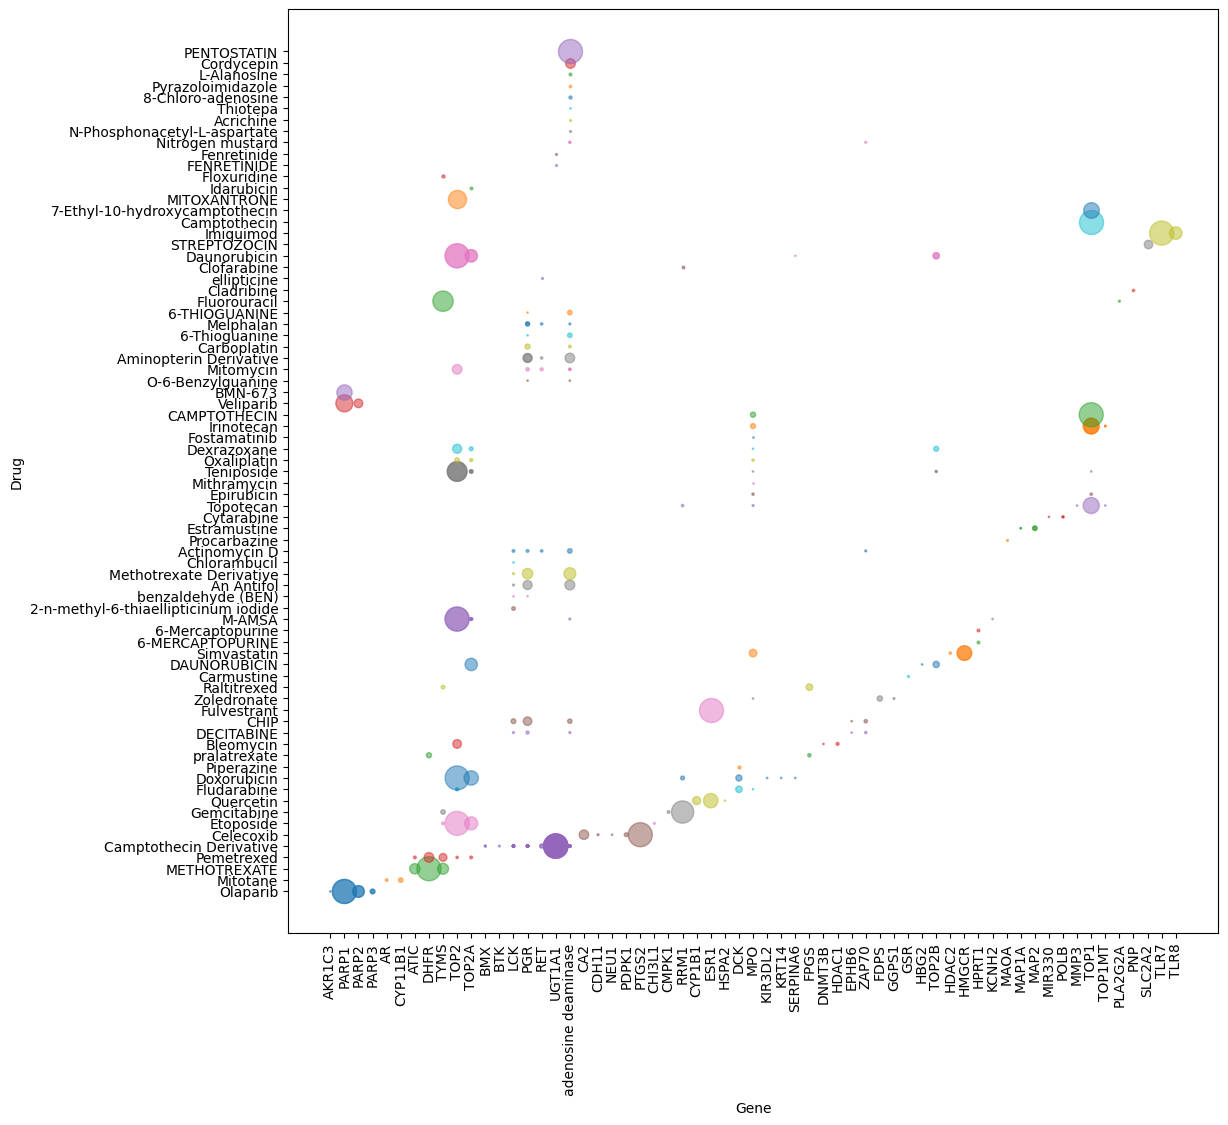

In [15]:
plt.figure(figsize=(12, 12))

# Creating a mapping for drugs to numerical values for plotting
unique_drugs = df['drug'].unique()
drug_mapping = {drug: i for i, drug in enumerate(unique_drugs)}

# Plotting
for drug in unique_drugs:
    subset = df[df['drug'] == drug]
    plt.scatter(subset['gene'], [drug_mapping[d] for d in subset['drug']], 
                s=subset['num'], alpha=0.5, label=drug)

# Set axis labels
plt.xlabel('Gene')
plt.ylabel('Drug')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=90)

# Set y-axis tick labels, ensuring that they are aligned to the left for better readability
plt.yticks(range(len(unique_drugs)), unique_drugs, ha='right')

# Display the plot
plt.show()

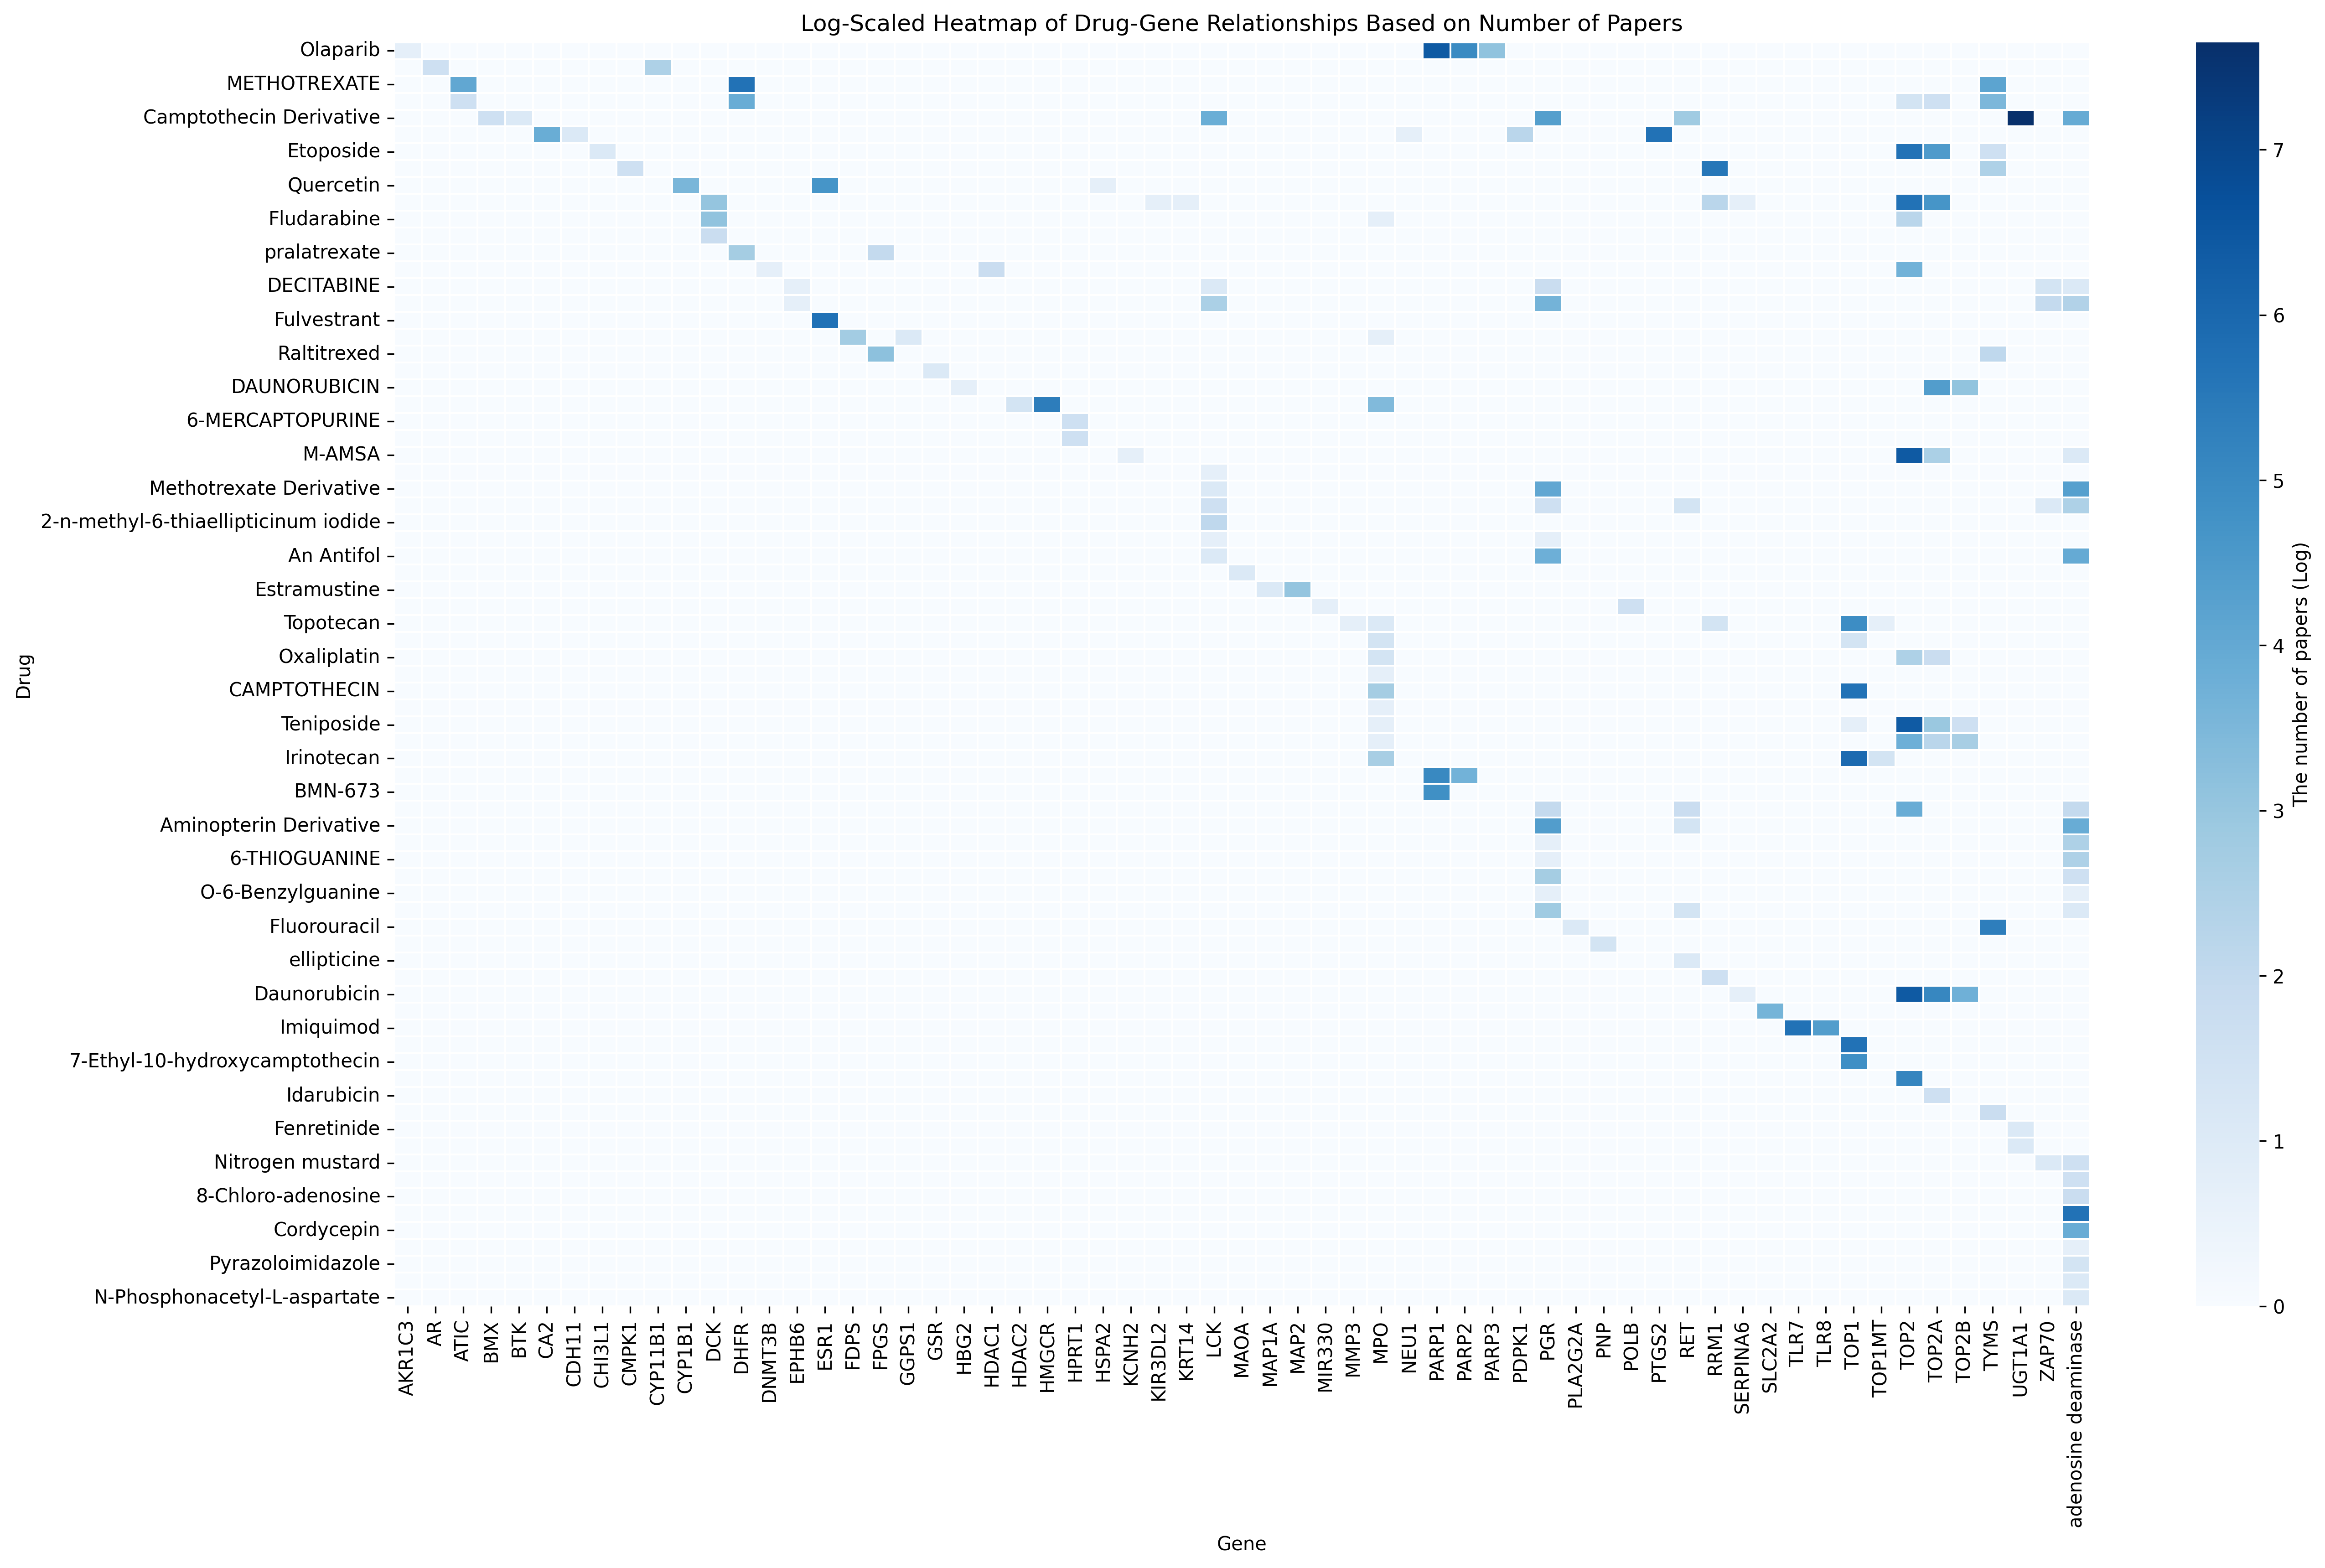

In [18]:
import seaborn as sns

bubble_data = df.groupby(['drug', 'gene'])['num'].sum().reset_index()
bubble_data = bubble_data.sort_values('gene')

pivot_table_data = bubble_data.pivot_table(values='num', index='drug', columns='gene', aggfunc='sum').fillna(0)
pivot_table_data.index = list(pivot_table_data.index)
pivot_table_data.columns = list(pivot_table_data.columns)
pivot_table_data = pivot_table_data.loc[bubble_data['drug'].unique()]

log_scale_data = np.log1p(pivot_table_data)

# Creating Heatmap without annotations (numbers)
plt.figure(figsize=(20, 12), dpi=300)
sns.heatmap(
    log_scale_data, annot=False, cmap='Blues', 
    linewidths=.5, cbar_kws={'label': 'The number of papers (Log)'}
)

plt.xticks(rotation=90)
plt.xlabel('Gene')
plt.ylabel('Drug')
plt.title('Log-Scaled Heatmap of Drug-Gene Relationships Based on Number of Papers')
plt.show()